In [3]:
import torch
import torch.nn as nn
import math
import triton
import triton.language as tl

class TritonFlashAttention(nn.Module):
    """
    Optimized Flash Attention implementation using Triton
    
    """
    def __init__(self, dim, heads=8, dropout=0.0):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.head_dim = dim // heads
        self.scale = self.head_dim ** -0.5
        
        # Query, Key, Value concatenation
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        
        # Output 
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )
        
        # Initializing with small values for training stability
        nn.init.xavier_normal_(self.to_qkv.weight, gain=0.01)
        nn.init.xavier_normal_(self.to_out[0].weight, gain=0.01)

    def forward(self, x):
        b, n, c = x.shape
        h = self.heads
        d = self.head_dim
        
        # Divide to queries, keys, values
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.reshape(b, n, h, d).permute(0, 2, 1, 3), qkv)
        
        # Calling Flash Attention kernel as per sequence length
        if q.is_cuda and n > 128:  # Use flash attention for longer sequences 
            out = flash_attention_forward(q, k, v, self.scale)
        else:
            # Use regular attention ie. on CPU for shorter sequences
            attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
            attn = torch.softmax(attn, dim=-1)
            out = torch.matmul(attn, v)
        
        # Reshape output 
        out = out.permute(0, 2, 1, 3).reshape(b, n, c)
        return self.to_out(out)


@triton.jit
def fwd_kernel(
    Q, K, V, sm_scale, Out,
    stride_qb, stride_qh, stride_qm, stride_qk,
    stride_kb, stride_kh, stride_kn, stride_kk,
    stride_vb, stride_vh, stride_vn, stride_vk,
    stride_ob, stride_oh, stride_om, stride_ok,
    B, H, M, N, D,  
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr,
):
    """
    Forward pass kernel for "Flash Attention"
    
    Parameters:
        Q: query tensor [B, H, M, K]
        K: key tensor [B, H, N, K]
        V: value tensor [B, H, N, K]
        sm_scale: float scaling factor for softmax
        Out: output tensor [B, H, M, K]
        stride_*: strides for the respective tensors
        B: batch size
        H: number of heads
        M: sequence length for queries
        N: sequence length for keys/values
        K: head dimension
        BLOCK_*: block sizes for tiling
    """
    # Program ID
    pid_m = tl.program_id(0)
    pid_b = tl.program_id(1)
    pid_h = tl.program_id(2)
    
    # Calculate offsets
    offs_m = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    offs_k = tl.arange(0, BLOCK_K)
    
    # Compute Q block pointer
    q_ptrs = Q + (pid_b * stride_qb + pid_h * stride_qh + 
                 offs_m[:, None] * stride_qm + offs_k[None, :] * stride_qk)
    
    # Initialize accumulator for softmax and output
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float('inf')
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32)
    acc = tl.zeros([BLOCK_M, BLOCK_K], dtype=tl.float32)
    
    # Load Q block
    q = tl.load(q_ptrs, mask=offs_m[:, None] < M, other=0.0)
    
    # Loop over K and V tiles
    for start_n in range(0, N, BLOCK_N):
        # Compute bounds
        start_n_offs = start_n + offs_n
        
        # Compute K and V block pointers
        k_ptrs = K + (pid_b * stride_kb + pid_h * stride_kh + 
                     start_n_offs[:, None] * stride_kn + offs_k[None, :] * stride_kk)
        v_ptrs = V + (pid_b * stride_vb + pid_h * stride_vh + 
                     start_n_offs[:, None] * stride_vn + offs_k[None, :] * stride_vk)
        
        # Load K and V blocks
        k = tl.load(k_ptrs, mask=start_n_offs[:, None] < N, other=0.0)
        v = tl.load(v_ptrs, mask=start_n_offs[:, None] < N, other=0.0)
        
        # Compute attention scores
        scores = tl.dot(q, tl.trans(k)) * sm_scale  # [BLOCK_M, BLOCK_N]
        
        # Compute max for numerical stability
        m_ij = tl.max(scores, axis=1)
        m_i_new = tl.maximum(m_i, m_ij)
        
        # Apply exp and scaling
        alpha = tl.exp(m_i - m_i_new)
        p = tl.exp(scores - m_ij[:, None])
        
        # Update accumulators
        l_ij = tl.sum(p, axis=1)
        l_i_new = l_i * alpha + l_ij
        acc_scale = alpha / l_i_new
        acc = acc * acc_scale[:, None]
        
        # Update attention output
        p_v = tl.dot(p, v)
        acc += p_v / l_i_new[:, None]
        
        # Update m_i and l_i for next iteration
        l_i = l_i_new
        m_i = m_i_new
    
    # Store result
    offs_o = pid_b * stride_ob + pid_h * stride_oh + offs_m[:, None] * stride_om + offs_k[None, :] * stride_ok
    out_ptrs = Out + offs_o
    tl.store(out_ptrs, acc, mask=offs_m[:, None] < M)


def flash_attention_forward(q, k, v, scale=1.0):
    """
    Applies flash attention using the Triton kernel
    
    Args:
        q: query tensor of shape [B, H, M, D]
        k: key tensor of shape [B, H, N, D]
        v: value tensor of shape [B, H, N, D]
        scale: scaling factor for softmax
    
    Returns:
        output tensor of shape [B, H, M, D]
    """
    # Extract dimensions
    batch_size, n_heads, seq_len_q, head_dim = q.shape
    _, _, seq_len_k, _ = k.shape
    
    # Allocate output tensor
    output = torch.empty_like(q)
    
    # Determine block sizes based on sequence length
    block_m = min(128, triton.next_power_of_2(seq_len_q))
    block_n = min(128, triton.next_power_of_2(seq_len_k))
    block_k = min(64, triton.next_power_of_2(head_dim))
    
    # Calculate grid
    grid = (
        triton.cdiv(seq_len_q, block_m),  # Number of blocks in M dimension
        batch_size,                       # Number of batches
        n_heads                           # Number of heads
    )
    
    # Launch kernel
    fwd_kernel[grid](
        q, k, v, scale, output,
        q.stride(0), q.stride(1), q.stride(2), q.stride(3),
        k.stride(0), k.stride(1), k.stride(2), k.stride(3),
        v.stride(0), v.stride(1), v.stride(2), v.stride(3),
        output.stride(0), output.stride(1), output.stride(2), output.stride(3),
        batch_size, n_heads, seq_len_q, seq_len_k, head_dim,
        BLOCK_M=block_m, BLOCK_N=block_n, BLOCK_K=block_k,
    )
    
    return output

Running benchmark on cuda
Benchmarking: batch_size=1, seq_len=128, dim=256, heads=8
  Triton Flash Attention: 0.28 ms
  Standard Attention: 0.22 ms
  Speedup: 0.78x
  Max diff: 0.000000

Benchmarking: batch_size=1, seq_len=256, dim=256, heads=8
  Triton Flash Attention: 0.30 ms
  Standard Attention: 0.23 ms
  Speedup: 0.76x
  Max diff: 0.000007

Benchmarking: batch_size=1, seq_len=512, dim=256, heads=8
  Triton Flash Attention: 0.28 ms
  Standard Attention: 0.23 ms
  Speedup: 0.80x
  Max diff: 0.000008

Benchmarking: batch_size=1, seq_len=1024, dim=256, heads=8
  Triton Flash Attention: 0.29 ms
  Standard Attention: 0.24 ms
  Speedup: 0.81x
  Max diff: 0.000006

Benchmarking: batch_size=1, seq_len=2048, dim=256, heads=8
  Triton Flash Attention: 0.35 ms
  Standard Attention: 0.57 ms
  Speedup: 1.63x
  Max diff: 0.000004

Benchmarking: batch_size=1, seq_len=4096, dim=256, heads=8
  Triton Flash Attention: 0.77 ms
  Standard Attention: 1.54 ms
  Speedup: 2.00x
  Max diff: 0.000003

Bench

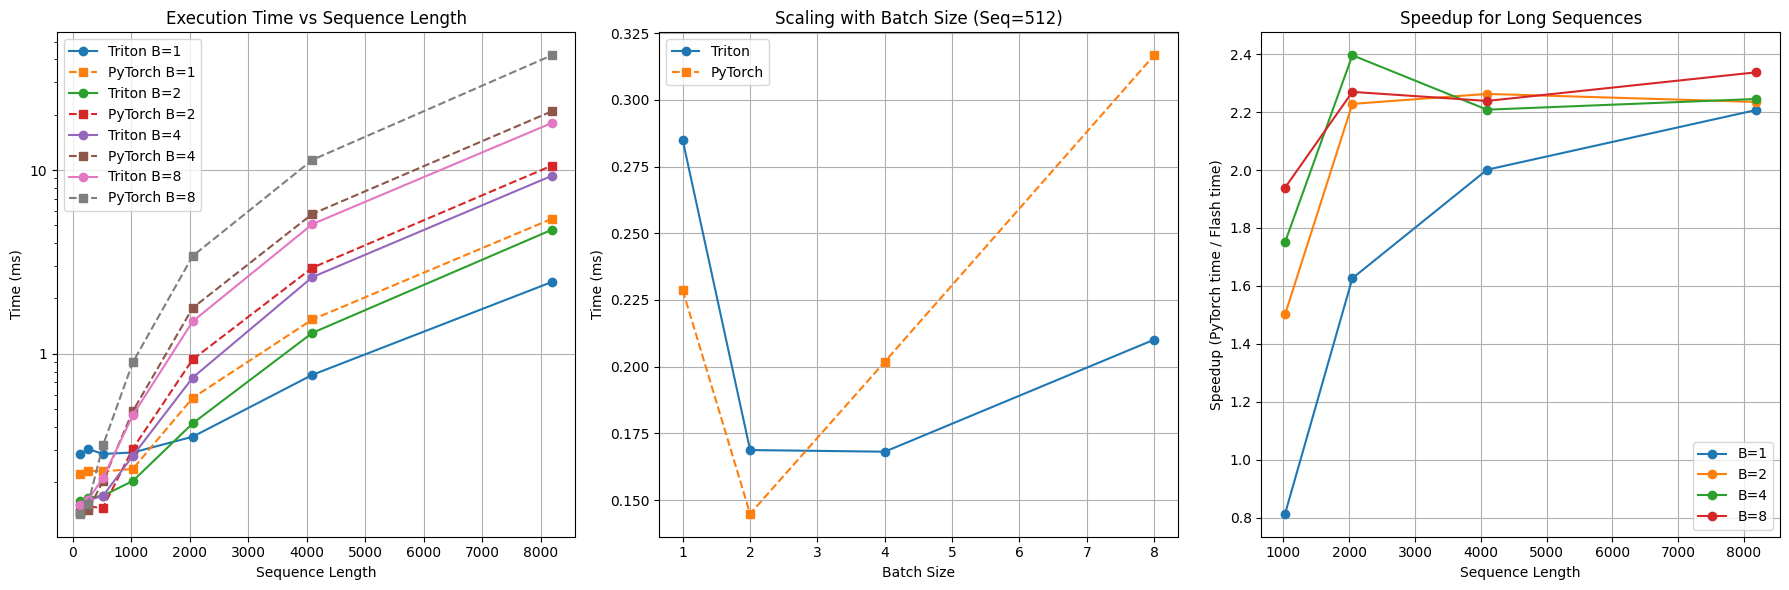

In [8]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt

class StandardAttention(torch.nn.Module):
    """Standard PyTorch attention implementation for comparison"""
    def __init__(self, dim, heads=8, dropout=0.0):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.head_dim = dim // heads
        self.scale = self.head_dim ** -0.5
        
        self.to_qkv = torch.nn.Linear(dim, dim * 3, bias=False)
        self.to_out = torch.nn.Sequential(
            torch.nn.Linear(dim, dim),
            torch.nn.Dropout(dropout)
        )
    
    def forward(self, x):
        b, n, c = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.reshape(b, n, self.heads, self.head_dim).permute(0, 2, 1, 3), qkv)
        
        # Standard attention computation
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = torch.softmax(attn, dim=-1)
        
        out = torch.matmul(attn, v)
        out = out.permute(0, 2, 1, 3).reshape(b, n, c)
        return self.to_out(out)


def benchmark(batch_sizes, seq_lengths, dim=256, heads=8, num_runs=10):
    """
    Benchmark Triton Flash Attention vs PyTorch Standard Attention
    
    Args:
        batch_sizes (list): List of batch sizes to test
        seq_lengths (list): List of sequence lengths to test
        dim (int): Model dimension
        heads (int): Number of attention heads
        num_runs (int): Number of runs for each configuration
    """
    results = {
        'batch_sizes': batch_sizes,
        'seq_lengths': seq_lengths,
        'triton_times': np.zeros((len(batch_sizes), len(seq_lengths))),
        'standard_times': np.zeros((len(batch_sizes), len(seq_lengths))),
        'speedups': np.zeros((len(batch_sizes), len(seq_lengths))),
        'max_diffs': np.zeros((len(batch_sizes), len(seq_lengths)))
    }
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running benchmark on {device}")
    
    for i, batch_size in enumerate(batch_sizes):
        for j, seq_len in enumerate(seq_lengths):
            print(f"Benchmarking: batch_size={batch_size}, seq_len={seq_len}, dim={dim}, heads={heads}")
            
            # Create input tensor
            x = torch.randn(batch_size, seq_len, dim, device=device)
            
            # Create models
            triton_attn = TritonFlashAttention(dim, heads).to(device)
            standard_attn = StandardAttention(dim, heads).to(device)
            
            # Set the same weights for fair comparison
            standard_attn.to_qkv.weight.data.copy_(triton_attn.to_qkv.weight.data)
            standard_attn.to_out[0].weight.data.copy_(triton_attn.to_out[0].weight.data)
            standard_attn.to_out[0].bias.data.copy_(triton_attn.to_out[0].bias.data)
            
            # Disable dropout
            triton_attn.to_out[1].p = 0
            standard_attn.to_out[1].p = 0
            
            # Benchmark Triton Flash Attention
            torch.cuda.synchronize()
            triton_times = []
            with torch.no_grad():
                for _ in range(num_runs):
                    start_time = time.time()
                    triton_output = triton_attn(x)
                    torch.cuda.synchronize()
                    triton_times.append(time.time() - start_time)
            triton_time = np.mean(triton_times) * 1000  # ms
            
            # Benchmark Standard PyTorch Attention
            torch.cuda.synchronize()
            standard_times = []
            with torch.no_grad():
                for _ in range(num_runs):
                    start_time = time.time()
                    standard_output = standard_attn(x)
                    torch.cuda.synchronize()
                    standard_times.append(time.time() - start_time)
            standard_time = np.mean(standard_times) * 1000  # ms
            
            # Compare difference in compute time
            max_diff = torch.max(torch.abs(triton_output - standard_output)).item()
            
            # Calculate speedup
            speedup = standard_time / triton_time
            
            # Store results
            results['triton_times'][i, j] = triton_time
            results['standard_times'][i, j] = standard_time
            results['speedups'][i, j] = speedup
            results['max_diffs'][i, j] = max_diff
            
            # Print results
            print(f"  Triton Flash Attention: {triton_time:.2f} ms")
            print(f"  Standard Attention: {standard_time:.2f} ms")
            print(f"  Speedup: {speedup:.2f}x")
            print(f"  Max diff: {max_diff:.6f}")
            print("")
    
    # Plot results
    plot_results(results)
    return results

def plot_results(results):
    
    """
    Plot benchmark results
    
    Args:
        results (dict): Benchmark results
    """
    batch_sizes = results['batch_sizes']
    seq_lengths = results['seq_lengths']
    
    # Create figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Subplot 1: Execution Time vs Sequence Length
    for i, batch_size in enumerate(batch_sizes):
        axs[0].plot(seq_lengths, results['triton_times'][i], 'o-', label=f'Triton B={batch_size}')
        axs[0].plot(seq_lengths, results['standard_times'][i], 's--', label=f'PyTorch B={batch_size}')
    
    axs[0].set_xlabel('Sequence Length')
    axs[0].set_ylabel('Time (ms)')
    axs[0].set_title('Execution Time vs Sequence Length')
    axs[0].set_yscale('log')
    axs[0].grid(True)
    axs[0].legend()

    from matplotlib.ticker import ScalarFormatter
    axs[0].yaxis.set_major_formatter(ScalarFormatter())
    
    # Subplot 2: Scaling with Batch Size
    seq_idx = 2 # Taking random sequence ie. Seq=512
    axs[1].plot(batch_sizes, results['triton_times'][:, seq_idx], 'o-', label='Triton')
    axs[1].plot(batch_sizes, results['standard_times'][:, seq_idx], 's--', label='PyTorch')
    axs[1].set_xlabel('Batch Size')
    axs[1].set_ylabel('Time (ms)')
    axs[1].set_title(f'Scaling with Batch Size (Seq={seq_lengths[seq_idx]})')
    axs[1].grid(True)
    axs[1].legend()
    
    # Subplot 3: Speedup for Long Sequences
    long_seq_indices = [j for j, seq_len in enumerate(seq_lengths) if seq_len >= 1024]
    if long_seq_indices:
        for i, batch_size in enumerate(batch_sizes):
            axs[2].plot(
                [seq_lengths[j] for j in long_seq_indices], 
                [results['speedups'][i, j] for j in long_seq_indices], 
                'o-', label=f'B={batch_size}'
            )
        
        axs[2].set_xlabel('Sequence Length')
        axs[2].set_ylabel('Speedup (PyTorch time / Flash time)')
        axs[2].set_title('Speedup for Long Sequences')
        axs[2].grid(True)
        axs[2].legend()
    
    plt.tight_layout()
    plt.savefig('flash_attention_benchmark.png')


if __name__ == "__main__":
    # Define benchmark parameters
    batch_sizes = [1, 2, 4, 8]
    seq_lengths = [128, 256, 512, 1024, 2048, 4096, 8192]
    
    # Run benchmark
    results = benchmark(batch_sizes, seq_lengths)
    
    # Print summary
    print("\nSummary of Results:")
    print("------------------")
    max_speedup = np.max(results['speedups'])
    max_i, max_j = np.unravel_index(np.argmax(results['speedups']), results['speedups'].shape)
    
    print(f"Best speedup: {max_speedup:.2f}x (Batch={results['batch_sizes'][max_i]}, Seq={results['seq_lengths'][max_j]})")
    
    # Check where Triton outperforms PyTorch
    wins = np.sum(results['speedups'] > 1.0)
    total = results['speedups'].size
    
    print(f"Triton outperforms PyTorch in {wins}/{total} configurations")
    
    # Print the configurations where Triton wins
    if wins > 0:
        print("\nConfigurations where Triton is faster:")
        for i, batch_size in enumerate(results['batch_sizes']):
            for j, seq_len in enumerate(results['seq_lengths']):
                if results['speedups'][i, j] > 1.0:
                    print(f"  Batch={batch_size}, Seq={seq_len}: {results['speedups'][i, j]:.2f}x speedup")